# Fake Review Detector

### Importing the necessary libraries

In [ ]:
!pip install nltk

In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import string
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

# from sklearn.naive_bayes import MultinomialNB
# from sklearn.svm import SVC

from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

### Supressing warnings

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Loading the dataset

In [3]:
df = pd.read_csv(r"fake-reviews-dataset.csv")
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


## Preprocessing

In [4]:
df.drop(columns = {'category'}, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rating  40432 non-null  float64
 1   label   40432 non-null  object 
 2   text_   40432 non-null  object 
dtypes: float64(1), object(2)
memory usage: 947.8+ KB


In [5]:
df.rename(columns = {'text_': 'text'}, inplace = True)
df.head()

,rating,label,text
0,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,5.0,CG,"love it, a great upgrade from the original. I..."
2,5.0,CG,This pillow saved my back. I love the look and...
3,1.0,CG,"Missing information on how to use it, but it i..."
4,5.0,CG,Very nice set. Good quality. We have had the s...


### Label encoding

In [6]:
def encode_label(df):
    labels = {
        'CG': 0,
        'OR': 1
    }
    
    df['target'] = df['label'].map(labels)
    return df

In [7]:
df = encode_label(df)
df['target'] = df['target'].fillna(0).replace([np.inf, -np.inf], 0)
df['target'] = df['target'].astype(int)

df.head()

,rating,label,text,target
0,5.0,CG,"Love this! Well made, sturdy, and very comfor...",0
1,5.0,CG,"love it, a great upgrade from the original. I...",0
2,5.0,CG,This pillow saved my back. I love the look and...,0
3,1.0,CG,"Missing information on how to use it, but it i...",0
4,5.0,CG,Very nice set. Good quality. We have had the s...,0


In [8]:
df.drop(columns = {'rating', 'label'}, inplace = True)

In [9]:
df = df.sample(frac=1).reset_index(drop=True)
df.sample(10)

,text,target
2154,"It zips-up high, well made, and has the wide b...",0
9094,Love these jars. They are a nice size and the...,0
19055,Love it! Perfect size and minimizes with no wi...,1
10325,Great story but I still felt like there is a l...,1
26632,I love these boots! I have an XL and they fit ...,0
7086,I am an independent reviewer and have never re...,0
24747,"We use this with our toddler as a ""learning to...",1
34821,The Greatest TV sitcom show. Excellent family...,0
38956,My 9 month old daughter loves it and she plays...,0
14105,This is a very good movie. The story is very g...,0


In [10]:
df.isnull().sum()

text      0
target    0
dtype: int64

In [11]:
df.duplicated().sum()

np.int64(20)

In [12]:
df.drop_duplicates(inplace = True)
df.duplicated().sum()

np.int64(0)

In [13]:
df['target'].value_counts()

target
1    20215
0    20197
Name: count, dtype: int64

### Text preprocessing

In [14]:
df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [15]:
df.head()

,text,target,num_characters,num_words,num_sentences
0,Was sure I read it was an easy way to feed the...,0,178,40,3
1,"I loved this purse. But, it didn't last long. ...",1,181,43,4
2,bought some about a year ago. just bought my ...,1,54,13,2
3,I have a small Cavalier King Charles girl who ...,1,525,111,8
4,really love this the material is really nice a...,1,89,17,1


## EDA

In [16]:
df.describe()

,target,num_characters,num_words,num_sentences
count,40412.000000,40412.000000,40412.000000,40412.000000
mean,0.500223,352.151787,76.691131,5.277071
std,0.500006,371.130271,79.242859,4.915033
min,0.000000,24.000000,2.000000,1.000000
25%,0.000000,107.000000,24.000000,2.000000
50%,1.000000,198.000000,44.000000,3.000000
75%,1.000000,440.000000,96.000000,6.000000
max,1.000000,2836.000000,510.000000,133.000000


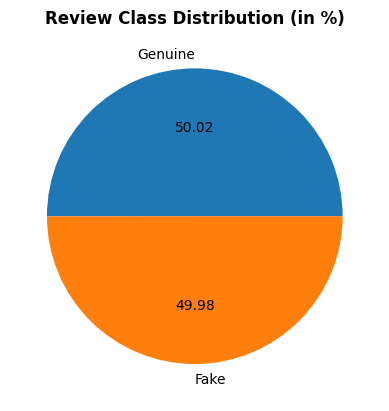

In [20]:
plt.pie(df['target'].value_counts(), labels=['Genuine', 'Fake'],autopct="%0.2f")

plt.title("Review Class Distribution (in %)", fontweight='bold')
plt.show()

### Correlational analysis

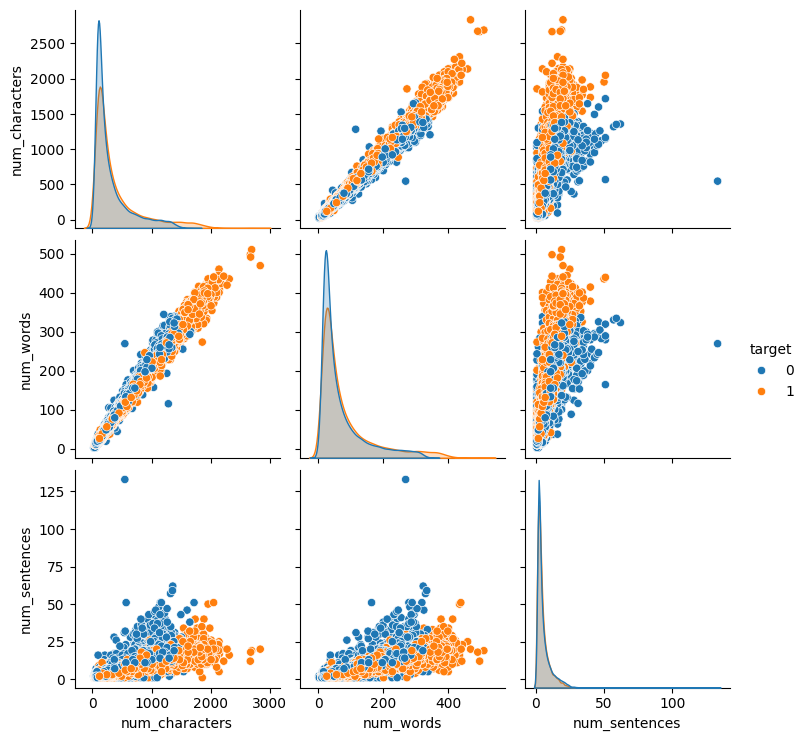

In [18]:
sns.pairplot(df,hue='target')
plt.show()

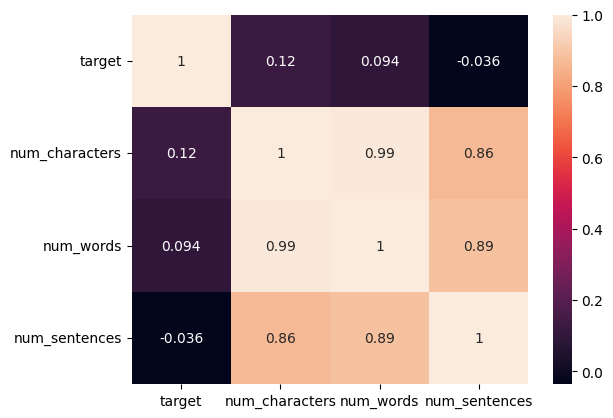

In [21]:
df_numeric = df.select_dtypes(include = 'number')
sns.heatmap(df_numeric.corr(),annot=True)

plt.show()

### Semantic analysis

In [22]:
ps = PorterStemmer()

In [23]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
    
    return " ".join(y)

In [24]:
transform_text("I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.")

'gon na home soon want talk stuff anymor tonight k cri enough today'

In [ ]:
df['transformed_text'] = df['text'].apply(transform_text)

In [ ]:
df.head()

In [ ]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
fake_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))

plt.figure(figsize=(15,6))
plt.imshow(fake_wc)

In [ ]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
original_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))

plt.figure(figsize=(15,6))
plt.imshow(original_wc)

In [ ]:
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=32)

## Model training

In [ ]:
# mnb = MultinomialNB()
# svc = SVC(probability=True, kernel='linear')

knc = KNeighborsClassifier()
dtc = DecisionTreeClassifier(max_depth=5)
xgb = XGBClassifier(n_estimators=50,random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)

In [ ]:
clfs = {
    'KN' : knc, 
    'DT' : dtc, 
    'LR' : lrc, 
    'RF' : rfc,
    'XGB' : xgb,
    'AdaBoost' : abc,
}

In [ ]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    
    return accuracy,precision

## Model evaluation

In [ ]:
accuracy_scores = []
precision_scores = []

for name, clf in clfs.items():
    current_accuracy, current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

In [ ]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)

In [ ]:
performance_df.reset_index(drop = True)

In [ ]:
# mnb = MultinomialNB()
# svc = SVC(probability=True, kernel='linear')

xgb = XGBClassifier(n_estimators=50,random_state=2)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)

In [ ]:
voting = VotingClassifier(estimators=[('LR', lrc), ('xgb', xgb), ('RF', rfc)],voting='soft')

In [ ]:
voting.fit(X_train,y_train)

In [ ]:
y_pred = voting.predict(X_test)

print("Accuracy :", round(accuracy_score(y_test,y_pred), 2) * 100, "%")
print("Precision :", round(precision_score(y_test,y_pred), 2) * 100, "%")

## Pickling
Pickling the **Logistic Regression** model for use in the web application.

In [ ]:
lrc.fit(X_train, y_train)

pickle.dump(lrc, open('model_v1.pkl', 'wb'))
pickle.dump(tfidf, open('vectorizer_v1.pkl','wb'))